This is an attempt to model the financial decision of renting vs buying a house according to a set of configurable parameters. The goal is to produce two plots

* Net worth of an individual that decided to rent over the next 30 years
* Net worth of an individual that decided to buy over the next 30 years

The parameters that can be configured should be
* Rent amount
* Inflation rate
* House price
* House down payment
* House mortgage interest rate
* House mortgage term
* House maintenance cost
* House appreciation rate
* House transaction cost
* Market returns
* Capital gains tax rate

The net worth of an individual who buys a house is calculated as

(the amount they can sell the house for) - (the amount that is remaining on the mortgage) - (taxes)

In [13]:
import pandas as pd
import matplotlib as plt
import numpy as np
import numpy_financial as npf
from utils import calculate_yearly_amortization_amounts


In [14]:
YEAR_START = 2023
ANALYSIS_TERM = 30
YEAR_END = YEAR_START + ANALYSIS_TERM
INFLATION_RATE = 0.04
INITIAL_RENT_AMOUNT = 1200 * 12         # we use annual rent
MARKET_RETURN = 0.05
HOUSE_PRICE = 350000
HOUSE_APPRECIATION_RATE = 0.02
HOUSE_MAINTENANCE_COST_RATE = 0.01
DOWN_PAYMENT_RATE = 0.5                 # we pay this much of the house price as down payment
LOAN_AMOUNT = HOUSE_PRICE * (1 - DOWN_PAYMENT_RATE)
CAPIAL_GAINS_TAX_RATE = 0.20
MORTGAGE_INTEREST_RATE = 0.03
MORGATGE_TERM = 30
BUYING_TRANSACTION_COST_RATE = 0.15     # amount of buying transaction cost to be paid as a percentage of the house price
                                        # this includes taxes and other fees
SELLING_TRANSACTION_COST_RATE = 0.10    # amount of selling transaction cost to be paid as a percentage of the house price
                                        # i need to understand this better


In [15]:
analysis = pd.DataFrame()

analysis.index = range(YEAR_START, YEAR_END)

analysis["inflation_rate"] = INFLATION_RATE
analysis["market_return"] = MARKET_RETURN
analysis["down_payment"] = HOUSE_PRICE * DOWN_PAYMENT_RATE
analysis["house_appreciation_rate"] = HOUSE_APPRECIATION_RATE

analysis["cumulative_inflation_rate"] = (1 + analysis["inflation_rate"]).cumprod()
analysis["cumulative_market_return"] = (1 + analysis["market_return"]).cumprod()

# renter calculations

analysis["rent_amount"] = INITIAL_RENT_AMOUNT * analysis["cumulative_inflation_rate"]
analysis["portfiolio_value"] = analysis["down_payment"] * analysis["cumulative_market_return"]
analysis["portfiolio_value_after_tax"] = analysis["portfiolio_value"] * (1 - CAPIAL_GAINS_TAX_RATE)
analysis["renter_net_woth"] = (
    analysis["portfiolio_value_after_tax"] - analysis["rent_amount"]
)

# buyer calculations

mortgage_payment_plan_yearly = calculate_yearly_amortization_amounts(
    year_start=YEAR_START,
    loan_amount=LOAN_AMOUNT,
    mortgage_periods=MORGATGE_TERM,
    mortgage_interest_rate=MORTGAGE_INTEREST_RATE,
)

analysis["cumulative_house_appreciation"] = (1 + analysis["house_appreciation_rate"]).cumprod()
analysis["house_value"] = HOUSE_PRICE * analysis["cumulative_house_appreciation"]
analysis["buying_transaction_cost"] = HOUSE_PRICE * BUYING_TRANSACTION_COST_RATE
analysis["mortgage_payment"] = mortgage_payment_plan_yearly["payment"]
analysis["mortgage_principal"] = mortgage_payment_plan_yearly["principal"]
analysis["mortgage_interest"] = mortgage_payment_plan_yearly["interest"]

analysis["house_value_after_tax"] = analysis["house_value"] * (1 - SELLING_TRANSACTION_COST_RATE)
analysis["cumulative_mortgage_principal"] = analysis["mortgage_principal"].cumsum()
analysis["buyer_net_worth"] = (
    analysis["house_value_after_tax"] -
    (analysis["house_value"] * HOUSE_MAINTENANCE_COST_RATE) -
    (analysis["buying_transaction_cost"]) -
    (LOAN_AMOUNT - analysis["cumulative_mortgage_principal"])
)


<Axes: title={'center': 'Renter vs Buyer Net Worth'}, xlabel='Year', ylabel='Net Worth (€)'>

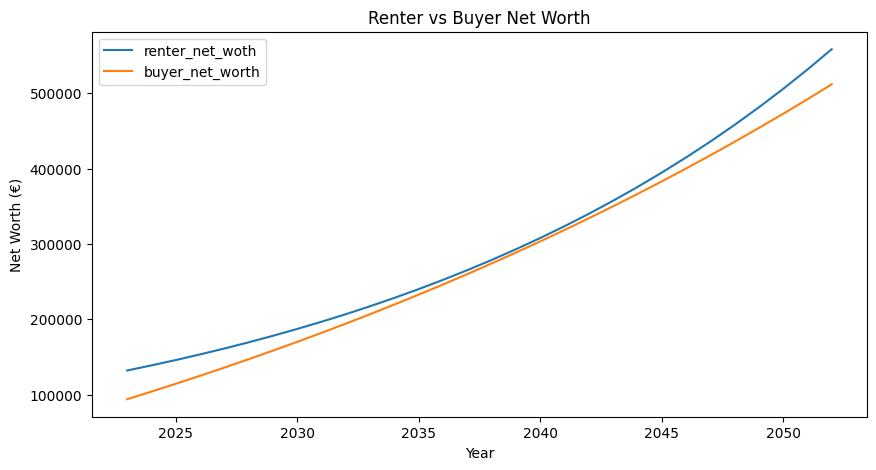

In [16]:
"""Diplay renter_net_woth and buyer_net_worth over time.
"""
analysis[["renter_net_woth", "buyer_net_worth"]].plot(
    title="Renter vs Buyer Net Worth",
    xlabel="Year",
    ylabel="Net Worth (€)",
    figsize=(10, 5)
)
